# Data exploration and validation

In this exercise we will cover how to use Polars and Pandera to explore, tidy, and validate the data.

## Task 1 - load data from database

### 🔄 Task

- Use `polars` to read the data from the database into a Polars dataframe.

### 🧑‍💻 Code

In [1]:
import os
from pathlib import Path

import polars as pl
from dotenv import load_dotenv

In [2]:
# Get the database credentials
if Path(".env").exists():
    print("loading .env")
    load_dotenv(override=True)

uri = os.environ["DATABASE_URI_PYTHON"]

loading .env


In [3]:
if os.getenv("TABLE_PREFIX"):
    username = os.environ["TABLE_PREFIX"]
else:
    username = os.environ["USER"]

username

'samedwardes'

Get the vessel verbose data set.

In [4]:
vessel_verbose = pl.read_database_uri(
    query=f"SELECT * FROM {username}_vessel_verbose_raw;",
    uri=uri,
    engine="adbc"
)

vessel_verbose

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassSubjectID,ClassName,SortSeq,DrawingImg,SilhouetteImg,PublicDisplayName,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,Beam,CityBuilt,SpeedInKnots,Draft,EngineCount,Horsepower,Length,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational
i64,i64,str,str,i64,i64,str,i64,str,str,str,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,str,i64,str,i64,i64,str,i64,bool,bool,str,i64,i64,i64,i64,i64,i64,i64,bool,i64
1,1,"""Cathlamet""","""CAT""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""78' 8""""","""Seattle, WA""",16,"""16' 6""""",2,5000,"""328'""",1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981,1993,false,null
2,2,"""Chelan""","""CHE""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""78' 8""""","""Seattle, WA""",16,"""16' 9""""",2,5000,"""328'""",1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981,2005,true,1090
65,428,"""Chetzemoka""","""CHZ""",162,427,"""Kwa-di Tabil""",75,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Kwa-di Tabil""",1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""64'""","""Seattle""",15,"""11'""",2,6000,"""273' 8""""",748,false,false,"""DIESEL""",192,64,9,4623,2415,2010,null,false,null
74,487,"""Chimacum""","""CHM""",100,319,"""Olympic""",35,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Olympic""",1,true,true,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""83' 2""""","""Seattle, WA""",17,"""18'""",2,6000,"""362' 3""""",1500,false,false,"""DIESEL""",192,144,34,3525,4384,2017,null,false,null
15,15,"""Issaquah""","""ISS""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Issaquah has elevator a…",""" ""","""""Snake."" Native Americans who …",""" ""","""78' 8""""","""Seattle, WA""",16,"""16' 6""""",2,5000,"""328'""",1200,false,false,"""DIESEL""",188,124,26,2475,3310,1979,1989,false,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
33,33,"""Tillikum""","""TIL""",20,311,"""Evergreen State""",60,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Evergreen State""",1,true,false,false,true,true,true,true,false,"""The MV Tillikum has an elevato…",""" ""","""Chinook Jargon: ""friends; rela…",""" ""","""73' 2""""","""Seattle, WA""",13,"""15 6""""",2,2500,"""310' 2""""",1061,false,false,"""DIESEL-ELECTRIC (AC)""",162,87,30,2070,2413,1959,1994,false,null
68,462,"""Tokitae""","""TOK""",100,319,"""Olympic""",35,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Olympic""",1,true,false,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""Tokitae means ""nice day, prett…","""Tokitae is the first of the 14…","""83' 2""""","""Seattle, WA""",17,"""18'""",2,6000,"""362' 3""""",1500,false,false,"""DIESEL""",192,144,34,3525,4384,2014,null,false,null
36,36,"""Walla Walla""","""WAL""",70,316,"""Jumbo""",20,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Jumbo""",1,true,false,false,true,true,true,true,fals

Get the vessel history data set.

In [5]:
vessel_history = pl.read_database_uri(
    query=f"SELECT * FROM {username}_vessel_history_raw;",
    uri=uri,
    engine="adbc"
)

vessel_history

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,str,str,str,str
32,"""Cathlamet""","""Vashon""","""Fauntleroy""","""/Date(1577886000000-0800)/""","""/Date(1577886072000-0800)/""","""/Date(1577887027000-0800)/""","""/Date(1577886000000-0800)/"""
32,"""Cathlamet""","""Fauntleroy""","""Vashon""","""/Date(1577887800000-0800)/""","""/Date(1577887897000-0800)/""","""/Date(1577888877000-0800)/""","""/Date(1577887800000-0800)/"""
32,"""Cathlamet""","""Vashon""","""Fauntleroy""","""/Date(1577889300000-0800)/""","""/Date(1577889457000-0800)/""","""/Date(1577890159000-0800)/""","""/Date(1577889300000-0800)/"""
32,"""Cathlamet""","""Fauntleroy""","""Vashon""","""/Date(1577891100000-0800)/""","""/Date(1577891231000-0800)/""","""/Date(1577892170000-0800)/""","""/Date(1577891100000-0800)/"""
32,"""Cathlamet""","""Vashon""","""Southworth""","""/Date(1577892600000-0800)/""","""/Date(1577892661000-0800)/""","""/Date(1577893331000-0800)/""","""/Date(1577892600000-0800)/"""
…,…,…,…,…,…,…,…
25,"""Yakima""","""Shaw""","""Anacortes""","""/Date(1721867400000-0700)/""","""/Date(1721872349000-0700)/""","""/Date(1721875674000-0700)/""","""/Date(1721867400000-0700)/"""
35,"""Yakima""","""Orcas""","""Shaw""","""/Date(1721870400000-0700)/""","""/Date(1721871272000-0700)/""","""/Date(1721872002000-0700)/""","""/Date(1721870400000-0700)/"""
25,"""Yakima""","""Anacortes""","""Lopez""","""/Date(1721880000000-0700)/""","""/Date(1721880638000-0700)/""","""/Date(1721883431000-0700)/""","""/Date(1721880000000-0700)/"""


Get the terminal locations data set.

In [6]:
terminal_locations = pl.read_database_uri(
    query=f"SELECT * FROM {username}_terminal_locations_raw;",
    uri=uri,
    engine="adbc"
)

terminal_locations

TerminalID,TerminalSubjectID,RegionID,TerminalName,TerminalAbbrev,SortSeq,Latitude,Longitude,AddressLineOne,AddressLineTwo,City,State,ZipCode,Country,MapLink,Directions
i64,i64,i64,str,str,i64,f64,f64,str,str,str,str,str,str,str,str
1,111,1,"""Anacortes""","""ANA""",10,48.507351,-122.677,"""2100 Ferry Terminal Road""",null,"""Anacortes""","""WA""","""98221""","""USA""","""https://www.google.com/maps/pl…","""From Interstate 5 take exit 23…"
3,103,4,"""Bainbridge Island""","""BBI""",40,47.622339,-122.509617,"""270 Olympic Drive SE""",null,"""Bainbridge Island""","""WA""","""98110""","""USA""","""http://maps.google.com/maps?f=…","""Northbound on Highway 3: Take …"
4,102,4,"""Bremerton""","""BRE""",30,47.561847,-122.624089,"""211 1st Street""",null,"""Bremerton""","""WA""","""98337""","""USA""","""https://www.google.com/maps/pl…","""Northbound on Highway 3: Exit…"
5,112,2,"""Clinton""","""CLI""",20,47.9754,-122.349581,"""64 South Ferrydock Road""",null,"""Clinton""","""WA""","""98236""","""USA""","""http://maps.yahoo.com/#mvt=m&l…","""Highway 20 on Whidbey Island t…"
11,116,2,"""Coupeville ""","""COU""",40,48.159008,-122.672603,"""1400 South State Route 20""",null,"""Coupeville""","""WA""","""98239""","""USA""","""https://maps.google.com/maps?q…","""Northbound/from Clinton ferry …"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
18,118,1,"""Shaw Island""","""SHI""",30,48.584792,-122.92965,"""PO Box 455 (Mailing)""","""12 Blind Bay Rd.""","""Shaw Island""","""WA""","""98286""","""USA""","""http://maps.yahoo.com/py/maps.…","""From Shaw Island County Park o…"
19,120,1,"""Sidney B.C.""","""SID""",60,48.643114,-123.396739,"""PO Box 2248 Mailing""","""2499 Ocean Avenue (Physical)""","""Sidney""","""BC""","""V8L1T3""","""Canada""",""" http://maps.google.com/maps?…","""<b>Sidney/Anacortes ferry Term…"
20,105,5,"""Southworth""","""SOU""",35,47.513064,-122.495742,"""11700 SE SEDGWICK RD""",null,"""Southworth""","""WA""","""98386""","""USA""","""http://maps.google.com/maps?q=…","""From I-5: Take exit 132 and pr…"


Get the terminal weather data set.

In [7]:
terminal_weather = pl.read_database_uri(
    query=f"SELECT * FROM {username}_terminal_weather_raw;",
    uri=uri,
    engine="adbc"
)

terminal_weather

latitude,longitude,generationtime_ms,utc_offset_seconds,timezone,timezone_abbreviation,elevation,time,weather_code,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,terminal_name
f64,f64,f64,i64,str,str,f64,str,i64,f64,f64,i64,f64,i64,f64,str
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T00:00""",53,8.6,0.5,100,42.4,145,43.9,"""Anacortes"""
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T01:00""",53,8.7,0.8,100,42.5,152,90.7,"""Anacortes"""
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T02:00""",53,8.9,0.6,100,38.2,166,56.5,"""Anacortes"""
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T03:00""",53,8.9,0.6,100,32.5,175,76.3,"""Anacortes"""
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T04:00""",53,10.3,0.6,64,40.5,225,52.2,"""Anacortes"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
47.486816,-122.512314,0.150084,0,"""GMT""","""GMT""",0.0,"""2024-07-24T19:00""",2,23.6,0.0,55,4.8,167,21.2,"""Vashon Island"""
47.486816,-122.512314,0.150084,0,"""GMT""","""GMT""",0.0,"""2024-07-24T20:00""",3,25.2,0.0,100,4.4,171,21.6,"""Vashon Island"""
47.486816,-122.512314,0.150084,0,"""GMT""","""GMT""",0.0,"""2024-07-24T21:00""",2,25.4,0.0,60,4.0,243,20.2,"""Vashon Island"""


## Task 2 - explore the data

### 🔄 Task

Begin exploring the data. You will want to understand:

- What columns exist in the data?
- How do the two data sets relate to one another?
- What is the type of each column (e.g. string, number, category, date)?
- Which columns could be useful for the model?
- What is the cardinality of categorical data?
- Is all of the data in scope?
- What steps will I need to perform to clean the data?

**Tips**

- Use VS Codes built in data viewer to explore the data.
- If you are more comfortable with Pandas, you can convert the polars dataframe into a pandas dataframe (e.g. `df.to_pandas()`).
- The polars user guide has great docs on how to use polars: https://docs.pola.rs.

🚨 We are not performing feature engineering at this stage. But it is a good time to start thinking about what features you can create from the data.

> 💡 We are not using it in this workshop, but `ydata-profiling` (<https://github.com/ydataai/ydata-profiling>) is a good tool for exploring a new data
set.

### 🧑‍💻 Code

#### vessel_history

In [8]:
vessel_history.head(3)

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,str,str,str,str
32,"""Cathlamet""","""Vashon""","""Fauntleroy""","""/Date(1577886000000-0800)/""","""/Date(1577886072000-0800)/""","""/Date(1577887027000-0800)/""","""/Date(1577886000000-0800)/"""
32,"""Cathlamet""","""Fauntleroy""","""Vashon""","""/Date(1577887800000-0800)/""","""/Date(1577887897000-0800)/""","""/Date(1577888877000-0800)/""","""/Date(1577887800000-0800)/"""
32,"""Cathlamet""","""Vashon""","""Fauntleroy""","""/Date(1577889300000-0800)/""","""/Date(1577889457000-0800)/""","""/Date(1577890159000-0800)/""","""/Date(1577889300000-0800)/"""


The dates and times are not formatted correctly. We can fix this when we tidy the data.

#### vessel_verbose

In [9]:
vessel_verbose.head(2)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassSubjectID,ClassName,SortSeq,DrawingImg,SilhouetteImg,PublicDisplayName,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,Beam,CityBuilt,SpeedInKnots,Draft,EngineCount,Horsepower,Length,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational
i64,i64,str,str,i64,i64,str,i64,str,str,str,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,str,i64,str,i64,i64,str,i64,bool,bool,str,i64,i64,i64,i64,i64,i64,i64,bool,i64
1,1,"""Cathlamet""","""CAT""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""78' 8""""","""Seattle, WA""",16,"""16' 6""""",2,5000,"""328'""",1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981,1993,false,null
2,2,"""Chelan""","""CHE""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""78' 8""""","""Seattle, WA""",16,"""16' 9""""",2,5000,"""328'""",1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981,2005,true,1090


How many different vessels are in the data?

In [10]:
vessel_verbose.select(pl.col("VesselID"), pl.col("VesselName"))

VesselID,VesselName
i64,str
1,"""Cathlamet"""
2,"""Chelan"""
65,"""Chetzemoka"""
74,"""Chimacum"""
15,"""Issaquah"""
…,…
33,"""Tillikum"""
68,"""Tokitae"""
36,"""Walla Walla"""


In [11]:
# Verify that each VesselID is unique.
vessel_verbose.get_column("VesselID").n_unique()

21

In [12]:
vessel_verbose.get_column("VesselID").n_unique() == vessel_verbose.shape[0]

True

What are all of the numerical columns?

In [13]:
vessel_verbose.select(pl.selectors.numeric()).head()

VesselID,VesselSubjectID,ClassID,ClassSubjectID,SortSeq,Status,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,MaxPassengerCountForInternational
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1,1,10,310,40,1,16,2,5000,1200,186,124,26,2477,3310,1981,1993,null
2,2,10,310,40,1,16,2,5000,1200,188,124,30,2477,3405,1981,2005,1090
65,428,162,427,75,1,15,2,6000,748,192,64,9,4623,2415,2010,null,null
74,487,100,319,35,1,17,2,6000,1500,192,144,34,3525,4384,2017,null,null
15,15,10,310,40,1,16,2,5000,1200,188,124,26,2475,3310,1979,1989,null


Some of the date based columns are integers or floats (e.g. `YearBuilt`). During data tidying we could convert them into a proper date type.


What are all of the string columns?

In [14]:
vessel_verbose.select(pl.selectors.string()).head()

VesselName,VesselAbbrev,ClassName,DrawingImg,SilhouetteImg,PublicDisplayName,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,Beam,CityBuilt,Draft,Length,PropulsionInfo
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""Cathlamet""","""CAT""","""Issaquah 130""","""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""78' 8""""","""Seattle, WA""","""16' 6""""","""328'""","""DIESEL"""
"""Chelan""","""CHE""","""Issaquah 130""","""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""78' 8""""","""Seattle, WA""","""16' 9""""","""328'""","""DIESEL"""
"""Chetzemoka""","""CHZ""","""Kwa-di Tabil""","""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Kwa-di Tabil""","""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""64'""","""Seattle""","""11'""","""273' 8""""","""DIESEL"""
"""Chimacum""","""CHM""","""Olympic""","""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Olympic""","""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""83' 2""""","""Seattle, WA""","""18'""","""362' 3""""","""DIESEL"""
"""Issaquah""","""ISS""","""Issaquah 130""","""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""","""The MV Issaquah has elevator a…",""" ""","""""Snake."" Native Americans who …",""" ""","""78' 8""""","""Seattle, WA""","""16' 6""""","""328'""","""DIESEL"""


- It looks like some missing values are represented with an empty string `""` while others have a `null` value. We may want to make this consistent when we tidy the data.
- Some string columns are measurements that should be converted into numeric types.

How much data is missing?

In [15]:
(
    vessel_verbose.null_count()
    .transpose(include_header=True)
    .rename({"column": "Column Name", "column_0": "Missing Rows"})
    .with_columns(
        ((pl.col("Missing Rows") / vessel_verbose.shape[0]) * 100)
        .round(1)
        .alias("% Missing")
    )
    .sort("Missing Rows", descending=True)
)

Column Name,Missing Rows,% Missing
str,u32,f64
"""MaxPassengerCountForInternatio…",20,95.2
"""YearRebuilt""",11,52.4
"""AdditionalInfo""",7,33.3
"""VesselHistory""",3,14.3
"""VesselID""",0,0.0
…,…,…
"""TallDeckSpace""",0,0.0
"""Tonnage""",0,0.0
"""Displacement""",0,0.0


#### terminal_locations

In the interest of time, we will not explore the `terminal_locations` data set. But you should explore it in the same way as the other data sets.

In [16]:
terminal_locations.head()

TerminalID,TerminalSubjectID,RegionID,TerminalName,TerminalAbbrev,SortSeq,Latitude,Longitude,AddressLineOne,AddressLineTwo,City,State,ZipCode,Country,MapLink,Directions
i64,i64,i64,str,str,i64,f64,f64,str,str,str,str,str,str,str,str
1,111,1,"""Anacortes""","""ANA""",10,48.507351,-122.677,"""2100 Ferry Terminal Road""",null,"""Anacortes""","""WA""","""98221""","""USA""","""https://www.google.com/maps/pl…","""From Interstate 5 take exit 23…"
3,103,4,"""Bainbridge Island""","""BBI""",40,47.622339,-122.509617,"""270 Olympic Drive SE""",null,"""Bainbridge Island""","""WA""","""98110""","""USA""","""http://maps.google.com/maps?f=…","""Northbound on Highway 3: Take …"
4,102,4,"""Bremerton""","""BRE""",30,47.561847,-122.624089,"""211 1st Street""",null,"""Bremerton""","""WA""","""98337""","""USA""","""https://www.google.com/maps/pl…","""Northbound on Highway 3: Exit…"
5,112,2,"""Clinton""","""CLI""",20,47.9754,-122.349581,"""64 South Ferrydock Road""",null,"""Clinton""","""WA""","""98236""","""USA""","""http://maps.yahoo.com/#mvt=m&l…","""Highway 20 on Whidbey Island t…"
11,116,2,"""Coupeville ""","""COU""",40,48.159008,-122.672603,"""1400 South State Route 20""",null,"""Coupeville""","""WA""","""98239""","""USA""","""https://maps.google.com/maps?q…","""Northbound/from Clinton ferry …"


#### terminal_weather

In the interest of time, we will not explore the `terminal_weather` data set. But you should explore it in the same way as the other data sets.

In [17]:
terminal_weather.head()

latitude,longitude,generationtime_ms,utc_offset_seconds,timezone,timezone_abbreviation,elevation,time,weather_code,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,terminal_name
f64,f64,f64,i64,str,str,f64,str,i64,f64,f64,i64,f64,i64,f64,str
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T00:00""",53,8.6,0.5,100,42.4,145,43.9,"""Anacortes"""
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T01:00""",53,8.7,0.8,100,42.5,152,90.7,"""Anacortes"""
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T02:00""",53,8.9,0.6,100,38.2,166,56.5,"""Anacortes"""
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T03:00""",53,8.9,0.6,100,32.5,175,76.3,"""Anacortes"""
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T04:00""",53,10.3,0.6,64,40.5,225,52.2,"""Anacortes"""


## Task 3 - Tidy the Data

### 🔄 Task

Now that you have a basic understanding of the data, the next step is to tidy the data.

### 🧑‍💻 Code

#### terminal_locations

In [18]:
terminal_locations.head()

TerminalID,TerminalSubjectID,RegionID,TerminalName,TerminalAbbrev,SortSeq,Latitude,Longitude,AddressLineOne,AddressLineTwo,City,State,ZipCode,Country,MapLink,Directions
i64,i64,i64,str,str,i64,f64,f64,str,str,str,str,str,str,str,str
1,111,1,"""Anacortes""","""ANA""",10,48.507351,-122.677,"""2100 Ferry Terminal Road""",null,"""Anacortes""","""WA""","""98221""","""USA""","""https://www.google.com/maps/pl…","""From Interstate 5 take exit 23…"
3,103,4,"""Bainbridge Island""","""BBI""",40,47.622339,-122.509617,"""270 Olympic Drive SE""",null,"""Bainbridge Island""","""WA""","""98110""","""USA""","""http://maps.google.com/maps?f=…","""Northbound on Highway 3: Take …"
4,102,4,"""Bremerton""","""BRE""",30,47.561847,-122.624089,"""211 1st Street""",null,"""Bremerton""","""WA""","""98337""","""USA""","""https://www.google.com/maps/pl…","""Northbound on Highway 3: Exit…"
5,112,2,"""Clinton""","""CLI""",20,47.9754,-122.349581,"""64 South Ferrydock Road""",null,"""Clinton""","""WA""","""98236""","""USA""","""http://maps.yahoo.com/#mvt=m&l…","""Highway 20 on Whidbey Island t…"
11,116,2,"""Coupeville ""","""COU""",40,48.159008,-122.672603,"""1400 South State Route 20""",null,"""Coupeville""","""WA""","""98239""","""USA""","""https://maps.google.com/maps?q…","""Northbound/from Clinton ferry …"


Clean the string values and keep only the desired columns.

In [19]:
terminal_locations_clean = terminal_locations.select(
    pl.col("TerminalName").str.to_lowercase().str.strip_chars(),
    pl.col("TerminalAbbrev").str.to_uppercase().str.strip_chars(),
    pl.col("Latitude"),
    pl.col("Longitude"),
)

terminal_locations_clean

TerminalName,TerminalAbbrev,Latitude,Longitude
str,str,f64,f64
"""anacortes""","""ANA""",48.507351,-122.677
"""bainbridge island""","""BBI""",47.622339,-122.509617
"""bremerton""","""BRE""",47.561847,-122.624089
"""clinton""","""CLI""",47.9754,-122.349581
"""coupeville""","""COU""",48.159008,-122.672603
…,…,…,…
"""shaw island""","""SHI""",48.584792,-122.92965
"""sidney b.c.""","""SID""",48.643114,-123.396739
"""southworth""","""SOU""",47.513064,-122.495742


#### terminal_weather

In [20]:
terminal_weather.head()

latitude,longitude,generationtime_ms,utc_offset_seconds,timezone,timezone_abbreviation,elevation,time,weather_code,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,terminal_name
f64,f64,f64,i64,str,str,f64,str,i64,f64,f64,i64,f64,i64,f64,str
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T00:00""",53,8.6,0.5,100,42.4,145,43.9,"""Anacortes"""
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T01:00""",53,8.7,0.8,100,42.5,152,90.7,"""Anacortes"""
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T02:00""",53,8.9,0.6,100,38.2,166,56.5,"""Anacortes"""
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T03:00""",53,8.9,0.6,100,32.5,175,76.3,"""Anacortes"""
48.541298,-122.727264,0.246048,0,"""GMT""","""GMT""",0.0,"""2020-01-01T04:00""",53,10.3,0.6,64,40.5,225,52.2,"""Anacortes"""


Tidy strings.

In [21]:
terminal_weather_clean = terminal_weather.with_columns(
    pl.col("timezone").str.to_lowercase().str.strip_chars(),
    pl.col("timezone_abbreviation").str.to_lowercase().str.strip_chars(),
    pl.col("terminal_name").str.to_lowercase().str.strip_chars(),
)

terminal_weather_clean.head()

latitude,longitude,generationtime_ms,utc_offset_seconds,timezone,timezone_abbreviation,elevation,time,weather_code,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,terminal_name
f64,f64,f64,i64,str,str,f64,str,i64,f64,f64,i64,f64,i64,f64,str
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,"""2020-01-01T00:00""",53,8.6,0.5,100,42.4,145,43.9,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,"""2020-01-01T01:00""",53,8.7,0.8,100,42.5,152,90.7,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,"""2020-01-01T02:00""",53,8.9,0.6,100,38.2,166,56.5,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,"""2020-01-01T03:00""",53,8.9,0.6,100,32.5,175,76.3,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,"""2020-01-01T04:00""",53,10.3,0.6,64,40.5,225,52.2,"""anacortes"""


Tidy datetime.

In [22]:
terminal_weather_clean = terminal_weather_clean.with_columns(
    pl.col("time").str.to_datetime(time_zone="GMT")
)

terminal_weather_clean.head()

latitude,longitude,generationtime_ms,utc_offset_seconds,timezone,timezone_abbreviation,elevation,time,weather_code,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,terminal_name
f64,f64,f64,i64,str,str,f64,"datetime[μs, GMT]",i64,f64,f64,i64,f64,i64,f64,str
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 00:00:00 GMT,53,8.6,0.5,100,42.4,145,43.9,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 01:00:00 GMT,53,8.7,0.8,100,42.5,152,90.7,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 02:00:00 GMT,53,8.9,0.6,100,38.2,166,56.5,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 03:00:00 GMT,53,8.9,0.6,100,32.5,175,76.3,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 04:00:00 GMT,53,10.3,0.6,64,40.5,225,52.2,"""anacortes"""


#### vessel_verbose

In [23]:
vessel_verbose.head(3)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassSubjectID,ClassName,SortSeq,DrawingImg,SilhouetteImg,PublicDisplayName,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,Beam,CityBuilt,SpeedInKnots,Draft,EngineCount,Horsepower,Length,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational
i64,i64,str,str,i64,i64,str,i64,str,str,str,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,str,i64,str,i64,i64,str,i64,bool,bool,str,i64,i64,i64,i64,i64,i64,i64,bool,i64
1,1,"""Cathlamet""","""CAT""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""78' 8""""","""Seattle, WA""",16,"""16' 6""""",2,5000,"""328'""",1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981,1993,false,null
2,2,"""Chelan""","""CHE""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""78' 8""""","""Seattle, WA""",16,"""16' 9""""",2,5000,"""328'""",1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981,2005,true,1090
65,428,"""Chetzemoka""","""CHZ""",162,427,"""Kwa-di Tabil""",75,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Kwa-di Tabil""",1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""64'""","""Seattle""",15,"""11'""",2,6000,"""273' 8""""",748,false,false,"""DIESEL""",192,64,9,4623,2415,2010,null,false,null


Convert the length measurements into a numeric value. Again we will use a function to capture this complex logic.

In [24]:
def convert_measurement_string_to_feet(series: pl.Series) -> pl.Series:
    """
    Convert the measurement string into a float.
    """
    feet = series.str.extract(r"(\d+)'").cast(pl.Int64)
    inches = series.str.extract(r'(\d+)"').cast(pl.Int64).fill_null(0)
    total_inches = feet * 12 + inches
    return total_inches


convert_measurement_string_to_feet(pl.Series(['''78' 8"''', """64'""", '''100' 11"''']))

""
i64
944
768
1211


In [25]:
vessel_verbose_clean = vessel_verbose.with_columns(
    pl.col("Beam", "Length", "Draft")
    .map_batches(lambda s: convert_measurement_string_to_feet(s))
    .name.suffix("Inches"),
).select(pl.col("*").exclude(["Beam", "Length", "Draft"]))

In [26]:
vessel_verbose_clean.head()

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassSubjectID,ClassName,SortSeq,DrawingImg,SilhouetteImg,PublicDisplayName,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,i64,i64,str,i64,str,str,str,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,i64,i64,bool,i64,i64,i64,i64
1,1,"""Cathlamet""","""CAT""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981,1993,false,null,944,3936,198
2,2,"""Chelan""","""CHE""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981,2005,true,1090,944,3936,201
65,428,"""Chetzemoka""","""CHZ""",162,427,"""Kwa-di Tabil""",75,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Kwa-di Tabil""",1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""Seattle""",15,2,6000,748,false,false,"""DIESEL""",192,64,9,4623,2415,2010,null,false,null,768,3284,132
74,487,"""Chimacum""","""CHM""",100,319,"""Olympic""",35,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Olympic""",1,true,true,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""Seattle, WA""",17,2,6000,1500,false,false,"""DIESEL""",192,144,34,3525,4384,2017,null,false,null,998,4347,216
15,15,"""Issaquah""","""ISS""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Issaquah has elevator a…",""" ""","""""Snake."" Native Americans who …",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,26,2475,3310,1979,1989,false,null,944,3936,198


Fix the dates.

In [27]:
vessel_verbose_clean = vessel_verbose_clean.with_columns(
    pl.col("YearBuilt").cast(pl.String).str.to_date("%Y"),
    pl.col("YearRebuilt").cast(pl.Int64).cast(pl.String).str.to_date("%Y"),
)

In [28]:
vessel_verbose_clean.head()

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassSubjectID,ClassName,SortSeq,DrawingImg,SilhouetteImg,PublicDisplayName,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,i64,i64,str,i64,str,str,str,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,bool,i64,i64,i64,i64
1,1,"""Cathlamet""","""CAT""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981-01-01,1993-01-01,false,null,944,3936,198
2,2,"""Chelan""","""CHE""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981-01-01,2005-01-01,true,1090,944,3936,201
65,428,"""Chetzemoka""","""CHZ""",162,427,"""Kwa-di Tabil""",75,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Kwa-di Tabil""",1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""Seattle""",15,2,6000,748,false,false,"""DIESEL""",192,64,9,4623,2415,2010-01-01,null,false,null,768,3284,132
74,487,"""Chimacum""","""CHM""",100,319,"""Olympic""",35,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Olympic""",1,true,true,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""Seattle, WA""",17,2,6000,1500,false,false,"""DIESEL""",192,144,34,3525,4384,2017-01-01,null,false,null,998,4347,216
15,15,"""Issaquah""","""ISS""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Issaquah has elevator a…",""" ""","""""Snake."" Native Americans who …",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,26,2475,3310,1979-01-01,1989-01-01,false,null,944,3936,198


Fix numeric types.

In [29]:
vessel_verbose_clean = vessel_verbose_clean.with_columns(
    pl.col("MaxPassengerCountForInternational").cast(pl.Int64),
)

In [30]:
vessel_verbose_clean.head()

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassSubjectID,ClassName,SortSeq,DrawingImg,SilhouetteImg,PublicDisplayName,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,i64,i64,str,i64,str,str,str,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,bool,i64,i64,i64,i64
1,1,"""Cathlamet""","""CAT""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",""" ""","""From the Kathlamet tribe, the …",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981-01-01,1993-01-01,false,null,944,3936,198
2,2,"""Chelan""","""CHE""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",""" ""","""From the Chelan language: Tsi…",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981-01-01,2005-01-01,true,1090,944,3936,201
65,428,"""Chetzemoka""","""CHZ""",162,427,"""Kwa-di Tabil""",75,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Kwa-di Tabil""",1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""Seattle""",15,2,6000,748,false,false,"""DIESEL""",192,64,9,4623,2415,2010-01-01,null,false,null,768,3284,132
74,487,"""Chimacum""","""CHM""",100,319,"""Olympic""",35,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Olympic""",1,true,true,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""Seattle, WA""",17,2,6000,1500,false,false,"""DIESEL""",192,144,34,3525,4384,2017-01-01,null,false,null,998,4347,216
15,15,"""Issaquah""","""ISS""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Issaquah has elevator a…",""" ""","""""Snake."" Native Americans who …",""" ""","""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,26,2475,3310,1979-01-01,1989-01-01,false,null,944,3936,198


Handle missing values for strings.

In [31]:
vessel_verbose_clean = vessel_verbose_clean.with_columns(
    pl.col(pl.String).replace(" ", None),
)

In [32]:
vessel_verbose_clean.head(2)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassSubjectID,ClassName,SortSeq,DrawingImg,SilhouetteImg,PublicDisplayName,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,i64,i64,str,i64,str,str,str,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,bool,i64,i64,i64,i64
1,1,"""Cathlamet""","""CAT""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",null,"""From the Kathlamet tribe, the …",null,"""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",186,124,26,2477,3310,1981-01-01,1993-01-01,false,null,944,3936,198
2,2,"""Chelan""","""CHE""",10,310,"""Issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",null,"""From the Chelan language: Tsi…",null,"""Seattle, WA""",16,2,5000,1200,false,false,"""DIESEL""",188,124,30,2477,3405,1981-01-01,2005-01-01,true,1090,944,3936,201


Normalize all of the string columns so that they are consistent.

In [33]:
vessel_verbose_clean = vessel_verbose_clean.with_columns(
    (
        pl.col("VesselName", "VesselAbbrev", "ClassName", "CityBuilt", "PropulsionInfo")
        .str.to_lowercase()
        .str.strip_chars()
    )
)

In [34]:
vessel_verbose_clean.head()

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassSubjectID,ClassName,SortSeq,DrawingImg,SilhouetteImg,PublicDisplayName,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,i64,i64,str,i64,str,str,str,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,bool,i64,i64,i64,i64
1,1,"""cathlamet""","""cat""",10,310,"""issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",null,"""From the Kathlamet tribe, the …",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",186,124,26,2477,3310,1981-01-01,1993-01-01,false,null,944,3936,198
2,2,"""chelan""","""che""",10,310,"""issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",null,"""From the Chelan language: Tsi…",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",188,124,30,2477,3405,1981-01-01,2005-01-01,true,1090,944,3936,201
65,428,"""chetzemoka""","""chz""",162,427,"""kwa-di tabil""",75,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Kwa-di Tabil""",1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""seattle""",15,2,6000,748,false,false,"""diesel""",192,64,9,4623,2415,2010-01-01,null,false,null,768,3284,132
74,487,"""chimacum""","""chm""",100,319,"""olympic""",35,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Olympic""",1,true,true,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""seattle, wa""",17,2,6000,1500,false,false,"""diesel""",192,144,34,3525,4384,2017-01-01,null,false,null,998,4347,216
15,15,"""issaquah""","""iss""",10,310,"""issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Issaquah has elevator a…",null,"""""Snake."" Native Americans who …",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",188,124,26,2475,3310,1979-01-01,1989-01-01,false,null,944,3936,198


#### vessel_history

In [35]:
vessel_history.head(2)

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,str,str,str,str
32,"""Cathlamet""","""Vashon""","""Fauntleroy""","""/Date(1577886000000-0800)/""","""/Date(1577886072000-0800)/""","""/Date(1577887027000-0800)/""","""/Date(1577886000000-0800)/"""
32,"""Cathlamet""","""Fauntleroy""","""Vashon""","""/Date(1577887800000-0800)/""","""/Date(1577887897000-0800)/""","""/Date(1577888877000-0800)/""","""/Date(1577887800000-0800)/"""


Convert the datetimes from strings to polars datetime objects. The logic is pretty complex. So we will abstract it into a function that we can apply to all of the required columns.

In [36]:
def convert_string_to_datetime(series: pl.Series) -> pl.Series:
    """
    Convert the datetime format from wadot into a datetime format that polars
    can understand.

    >>> convert_string_to_datetime(pl.Series(['/Date(1714547700000-0700)/']))
    shape: (1,)
    Series: '' [datetime[μs, UTC]]
    [
        2024-05-01 07:15:00 UTC
    ]
    """
    # Extract the unix time stamp. To work with polars we need the time
    # the number of seconds since 1970-01-01 00:00 UTC, so divide by
    # 1_000.
    unix_timestamp = (
        (series.str.extract(r"/Date\((\d{13})[-+]").cast(pl.Int64) / 1_000)
        .cast(pl.Int64)
        .cast(pl.String)
    )
    # Extract the timezone.
    timezone = series.str.extract(r"([-+]\d{4})")
    # Create a new series that has the timestamp and timezone.
    clean_timestamp = unix_timestamp + timezone
    # Convert into a datetime.
    datetime_series = clean_timestamp.str.to_datetime("%s%z")
    return datetime_series


convert_string_to_datetime(pl.Series(["/Date(1714547700000-0700)/"]))

""
"datetime[μs, UTC]"
2024-05-01 07:15:00 UTC


In [37]:
vessel_history_clean = vessel_history.with_columns(
    (
        pl.col("ScheduledDepart", "ActualDepart", "EstArrival", "Date").map_batches(
            lambda s: convert_string_to_datetime(s)
        )
    )
)

In [38]:
vessel_history_clean.head()

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]"
32,"""Cathlamet""","""Vashon""","""Fauntleroy""",2020-01-01 13:40:00 UTC,2020-01-01 13:41:12 UTC,2020-01-01 13:57:07 UTC,2020-01-01 13:40:00 UTC
32,"""Cathlamet""","""Fauntleroy""","""Vashon""",2020-01-01 14:10:00 UTC,2020-01-01 14:11:37 UTC,2020-01-01 14:27:57 UTC,2020-01-01 14:10:00 UTC
32,"""Cathlamet""","""Vashon""","""Fauntleroy""",2020-01-01 14:35:00 UTC,2020-01-01 14:37:37 UTC,2020-01-01 14:49:19 UTC,2020-01-01 14:35:00 UTC
32,"""Cathlamet""","""Fauntleroy""","""Vashon""",2020-01-01 15:05:00 UTC,2020-01-01 15:07:11 UTC,2020-01-01 15:22:50 UTC,2020-01-01 15:05:00 UTC
32,"""Cathlamet""","""Vashon""","""Southworth""",2020-01-01 15:30:00 UTC,2020-01-01 15:31:01 UTC,2020-01-01 15:42:11 UTC,2020-01-01 15:30:00 UTC


Normalize all of the string columns so that they are consistent.

In [39]:
vessel_history_clean = vessel_history_clean.with_columns(
    (pl.col("Vessel", "Departing", "Arriving").str.to_lowercase().str.strip_chars())
)

In [40]:
vessel_history_clean.head()

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]"
32,"""cathlamet""","""vashon""","""fauntleroy""",2020-01-01 13:40:00 UTC,2020-01-01 13:41:12 UTC,2020-01-01 13:57:07 UTC,2020-01-01 13:40:00 UTC
32,"""cathlamet""","""fauntleroy""","""vashon""",2020-01-01 14:10:00 UTC,2020-01-01 14:11:37 UTC,2020-01-01 14:27:57 UTC,2020-01-01 14:10:00 UTC
32,"""cathlamet""","""vashon""","""fauntleroy""",2020-01-01 14:35:00 UTC,2020-01-01 14:37:37 UTC,2020-01-01 14:49:19 UTC,2020-01-01 14:35:00 UTC
32,"""cathlamet""","""fauntleroy""","""vashon""",2020-01-01 15:05:00 UTC,2020-01-01 15:07:11 UTC,2020-01-01 15:22:50 UTC,2020-01-01 15:05:00 UTC
32,"""cathlamet""","""vashon""","""southworth""",2020-01-01 15:30:00 UTC,2020-01-01 15:31:01 UTC,2020-01-01 15:42:11 UTC,2020-01-01 15:30:00 UTC


It was identified that many rows have no "Arriving" terminal, or "EstArrival" date. We will assume that it means these ferries were cancelled and drop these rows.

In [41]:
(
    vessel_history_clean.filter(
        pl.col("Arriving").is_null() | pl.col("EstArrival").is_null()
    )
)

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]"
31,"""cathlamet""","""vashon""",null,2020-01-28 17:55:00 UTC,2020-01-28 18:07:18 UTC,null,2020-01-28 17:55:00 UTC
29,"""cathlamet""","""fauntleroy""",null,2020-01-28 18:40:00 UTC,2020-01-28 18:38:59 UTC,null,2020-01-28 18:40:00 UTC
31,"""cathlamet""","""vashon""",null,2020-01-28 18:55:00 UTC,2020-01-28 18:59:09 UTC,null,2020-01-28 18:55:00 UTC
31,"""cathlamet""","""southworth""",null,2020-01-28 19:20:00 UTC,2020-01-28 19:21:36 UTC,null,2020-01-28 19:20:00 UTC
31,"""cathlamet""","""vashon""",null,2020-01-28 19:50:00 UTC,2020-01-28 19:52:34 UTC,null,2020-01-28 19:50:00 UTC
…,…,…,…,…,…,…,…
27,"""yakima""","""orcas""",null,2023-08-14 16:15:00 UTC,2023-08-14 16:33:45 UTC,null,2023-08-14 16:15:00 UTC
27,"""yakima""","""shaw""",null,2023-08-14 16:30:00 UTC,2023-08-14 16:50:45 UTC,null,2023-08-14 16:30:00 UTC
2522,"""yakima""","""lopez""",null,2024-01-09 18:20:00 UTC,2024-01-09 19:32:52 UTC,null,2024-01-09 18:20:00 UTC


In [42]:
vessel_history_clean = vessel_history_clean.filter(
    pl.col("Arriving").is_not_null(), pl.col("EstArrival").is_not_null()
)

In [43]:
vessel_history_clean.head()

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]"
32,"""cathlamet""","""vashon""","""fauntleroy""",2020-01-01 13:40:00 UTC,2020-01-01 13:41:12 UTC,2020-01-01 13:57:07 UTC,2020-01-01 13:40:00 UTC
32,"""cathlamet""","""fauntleroy""","""vashon""",2020-01-01 14:10:00 UTC,2020-01-01 14:11:37 UTC,2020-01-01 14:27:57 UTC,2020-01-01 14:10:00 UTC
32,"""cathlamet""","""vashon""","""fauntleroy""",2020-01-01 14:35:00 UTC,2020-01-01 14:37:37 UTC,2020-01-01 14:49:19 UTC,2020-01-01 14:35:00 UTC
32,"""cathlamet""","""fauntleroy""","""vashon""",2020-01-01 15:05:00 UTC,2020-01-01 15:07:11 UTC,2020-01-01 15:22:50 UTC,2020-01-01 15:05:00 UTC
32,"""cathlamet""","""vashon""","""southworth""",2020-01-01 15:30:00 UTC,2020-01-01 15:31:01 UTC,2020-01-01 15:42:11 UTC,2020-01-01 15:30:00 UTC


Correct the names of the "Departing" and "Arriving" terminals so that they match the values in the `terminal_locations` data set.

In [44]:
terminal_name_mapping = {
    "anacortes": "anacortes",
    "bainbridge": "bainbridge island",
    "bremerton": "bremerton",
    "clinton": "clinton",
    "colman": "seattle",
    "edmonds": "edmonds",
    "fauntleroy": "fauntleroy",
    "friday harbor": "friday harbor",
    "keystone": "coupeville",
    "kingston": "kingston",
    "lopez": "lopez island",
    "mukilteo": "mukilteo",
    "orcas": "orcas island",
    "port townsend": "port townsend",
    "pt. defiance": "point defiance",
    "shaw": "shaw island",
    "sidney b. c.": "sidney b.c.",
    "southworth": "southworth",
    "tahlequah": "tahlequah",
    "vashon": "vashon island",
}

In [45]:
terminal_name_mapping_df = pl.DataFrame(
    {
        "OldName": terminal_name_mapping.keys(),
        "CorrectName": terminal_name_mapping.values(),
    }
)

terminal_name_mapping_df

OldName,CorrectName
str,str
"""anacortes""","""anacortes"""
"""bainbridge""","""bainbridge island"""
"""bremerton""","""bremerton"""
"""clinton""","""clinton"""
"""colman""","""seattle"""
…,…
"""shaw""","""shaw island"""
"""sidney b. c.""","""sidney b.c."""
"""southworth""","""southworth"""


In [46]:
vessel_history_clean = (
    vessel_history_clean.join(
        terminal_name_mapping_df,
        left_on="Departing",
        right_on="OldName",
        how="left",
        validate="m:1",
        coalesce=True
    )
    .rename({"CorrectName": "DepartingCorrected"})
    .join(
        terminal_name_mapping_df,
        left_on="Arriving",
        right_on="OldName",
        how="left",
        validate="m:1",
        coalesce=True
    )
    .rename({"CorrectName": "ArrivingCorrected"})
    .drop(["Departing", "Arriving"])
    .rename({"DepartingCorrected": "Departing", "ArrivingCorrected": "Arriving"})
    .select(
        [
            "VesselId",
            "Vessel",
            "Departing",
            "Arriving",
            "ScheduledDepart",
            "ActualDepart",
            "EstArrival",
            "Date",
        ]
    )
)

In [47]:
vessel_history_clean.head()

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
i64,str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]"
32,"""cathlamet""","""vashon island""","""fauntleroy""",2020-01-01 13:40:00 UTC,2020-01-01 13:41:12 UTC,2020-01-01 13:57:07 UTC,2020-01-01 13:40:00 UTC
32,"""cathlamet""","""fauntleroy""","""vashon island""",2020-01-01 14:10:00 UTC,2020-01-01 14:11:37 UTC,2020-01-01 14:27:57 UTC,2020-01-01 14:10:00 UTC
32,"""cathlamet""","""vashon island""","""fauntleroy""",2020-01-01 14:35:00 UTC,2020-01-01 14:37:37 UTC,2020-01-01 14:49:19 UTC,2020-01-01 14:35:00 UTC
32,"""cathlamet""","""fauntleroy""","""vashon island""",2020-01-01 15:05:00 UTC,2020-01-01 15:07:11 UTC,2020-01-01 15:22:50 UTC,2020-01-01 15:05:00 UTC
32,"""cathlamet""","""vashon island""","""southworth""",2020-01-01 15:30:00 UTC,2020-01-01 15:31:01 UTC,2020-01-01 15:42:11 UTC,2020-01-01 15:30:00 UTC


Tidy the vessel history data so that the relationship between vessel history and vessel verbose is correct.

It was identified that joins based on `VesselId` are not complete.

In [48]:
(
    vessel_history_clean.join(
        vessel_verbose_clean,
        left_on="VesselId",
        right_on="VesselID",
        how="left",
        validate="m:1",
        coalesce=True
    )
    # Filter to show all of the rows where there was no matching Vessel ID in the
    # vessel_verbose_clean DataFrame.
    .filter(pl.col("VesselAbbrev").is_null())
)

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassSubjectID,ClassName,SortSeq,DrawingImg,SilhouetteImg,PublicDisplayName,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]",i64,str,str,i64,i64,str,i64,str,str,str,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,bool,i64,i64,i64,i64
29,"""cathlamet""","""vashon island""","""fauntleroy""",2020-01-04 05:55:00 UTC,2020-01-04 06:03:35 UTC,2020-01-04 06:16:53 UTC,2020-01-04 05:55:00 UTC,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
31,"""cathlamet""","""southworth""","""vashon island""",2020-01-04 12:20:00 UTC,2020-01-04 12:02:30 UTC,2020-01-04 12:16:06 UTC,2020-01-04 12:20:00 UTC,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
31,"""cathlamet""","""vashon island""","""fauntleroy""",2020-01-07 18:40:00 UTC,2020-01-07 19:05:19 UTC,2020-01-07 19:18:58 UTC,2020-01-07 18:40:00 UTC,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
29,"""cathlamet""","""vashon island""","""fauntleroy""",2020-01-18 05:55:00 UTC,2020-01-18 06:03:33 UTC,2020-01-18 06:16:12 UTC,2020-01-18 05:55:00 UTC,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
31,"""cathlamet""","""vashon island""","""fauntleroy""",2020-01-28 12:05:00 UTC,2020-01-28 12:06:13 UTC,2020-01-28 12:20:33 UTC,2020-01-28 12:05:00 UTC,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
35,"""yakima""","""orcas island""","""shaw island""",2024-06-19 16:15:00 UTC,2024-06-19 16:12:15 UTC,2024-06-19 16:21:45 UTC,2024-06-19 16:15:00 UTC,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
35,"""yakima""","""shaw island""","""lopez island""",2024-06-19 16:30:00 UTC,2024-06-19 16:29:15 UTC,2024-06-19 16:47:14 UTC,2024-06-19 16:30:00 UTC,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
35,"""yakima""","""orcas island""","""shaw island""",2024-07-10 16:15:00 UTC,2024-07-10 16:11:16 UTC,2024-07-10 16:18:43 UTC,2024-07-10 16:15:00 UTC,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


However, joins based on `Vessel` and `VesselName` are complete.

In [49]:
(
    vessel_history_clean.join(
        vessel_verbose_clean,
        left_on="Vessel",
        right_on="VesselName",
        how="left",
        validate="m:1",
        coalesce=True
    )
    # Filter to show all of the rows where there was no matching Vessel ID in the
    # vessel_verbose_clean DataFrame. If no rows are returned, then the join was
    # successful.
    .filter(pl.col("VesselAbbrev").is_null())
)

VesselId,Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date,VesselID,VesselSubjectID,VesselAbbrev,ClassID,ClassSubjectID,ClassName,SortSeq,DrawingImg,SilhouetteImg,PublicDisplayName,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]",i64,i64,str,i64,i64,str,i64,str,str,str,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,bool,i64,i64,i64,i64


Therefore we should drop the `VesselId` from the data since it is not correct or useful.

In [50]:
vessel_history_clean = vessel_history_clean.drop("VesselId")

In [51]:
vessel_history_clean.head()

Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]"
"""cathlamet""","""vashon island""","""fauntleroy""",2020-01-01 13:40:00 UTC,2020-01-01 13:41:12 UTC,2020-01-01 13:57:07 UTC,2020-01-01 13:40:00 UTC
"""cathlamet""","""fauntleroy""","""vashon island""",2020-01-01 14:10:00 UTC,2020-01-01 14:11:37 UTC,2020-01-01 14:27:57 UTC,2020-01-01 14:10:00 UTC
"""cathlamet""","""vashon island""","""fauntleroy""",2020-01-01 14:35:00 UTC,2020-01-01 14:37:37 UTC,2020-01-01 14:49:19 UTC,2020-01-01 14:35:00 UTC
"""cathlamet""","""fauntleroy""","""vashon island""",2020-01-01 15:05:00 UTC,2020-01-01 15:07:11 UTC,2020-01-01 15:22:50 UTC,2020-01-01 15:05:00 UTC
"""cathlamet""","""vashon island""","""southworth""",2020-01-01 15:30:00 UTC,2020-01-01 15:31:01 UTC,2020-01-01 15:42:11 UTC,2020-01-01 15:30:00 UTC


## Task 4 - Validate the Data

### 🔄 Task

In the previous activity we tidied the dataset. For some projects, this may be enough. However, for this project we plan to refresh the data on a regular basis. We would like to gain additional comfort that the data we are using is correct. Data validation can help prove that our data tidying was correct, and find any potential issues if the upstream data changes.

[Pandera](https://pandera.readthedocs.io/en/stable/) is a Python library for validating Pandas dataframes. There are two steps:

1. Define a schema for your data. For example:
   - Define the type for each column
   - Confirm if null values are allowed
   - Define custom checks
2. Run your data through the schema validator.

You will find these links useful when defining your schema:

- Polars data validation guide: https://pandera.readthedocs.io/en/stable/polars.html#usage
- Polars data types: https://pandera.readthedocs.io/en/stable/reference/dtypes.html#polars-dtypes
- `pa.Field` API: https://pandera.readthedocs.io/en/stable/reference/generated/pandera.api.dataframe.model_components.Field.html#pandera.api.dataframe.model_components.Field
- List of built in checks you can use with `pa.Field`: https://pandera.readthedocs.io/en/stable/reference/generated/pandera.api.checks.Check.html#pandera.api.checks.Check

Before working on our real data, lets play around with a "toy" example. Take a few minutes and play around with the example below:

- Can you run the code as is?
- Try channging some of the values in the DataFrame so that the schema validation fails.
- Try updating the schema so that it passes again.

In [52]:
import pandera.polars as pa

In [53]:
# data to validate
df = pl.DataFrame({
    "column1": [1, 11, 0, 10, 9],
    "column2": [-1.3, -1.4, -2.9, -10.1, -5.2],
    "column3": ["value_1", "value_2", "value_3", "value_2", "value_1"],
})

df

column1,column2,column3
i64,f64,str
1,-1.3,"""value_1"""
11,-1.4,"""value_2"""
0,-2.9,"""value_3"""
10,-10.1,"""value_2"""
9,-5.2,"""value_1"""


In [54]:
class ToySchema(pa.DataFrameModel):
    column1: int = pa.Field(le=11)
    column2: float = pa.Field(lt=1.2)
    column3: str = pa.Field(str_startswith="value_")

    @pa.check("column3")
    def column3_has_one_underscore(cls, data: pa.PolarsData) -> pl.LazyFrame:
        list_is_len_2 = (
            data
            .lazyframe
            .select(
                pl.col(data.key).str.split("_").list.len() == 2
            )
        )
        # print(list_is_len_2.collect())
        return list_is_len_2

In [55]:
ToySchema.validate(df)

column1,column2,column3
i64,f64,str
1,-1.3,"""value_1"""
11,-1.4,"""value_2"""
0,-2.9,"""value_3"""
10,-10.1,"""value_2"""
9,-5.2,"""value_1"""


### 🧑‍💻 Code

#### vessel_history

Start by validating the `vessel_history` data set. As a reminder, here is what the data looks like:

In [56]:
vessel_history_clean.head(3)

Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]"
"""cathlamet""","""vashon island""","""fauntleroy""",2020-01-01 13:40:00 UTC,2020-01-01 13:41:12 UTC,2020-01-01 13:57:07 UTC,2020-01-01 13:40:00 UTC
"""cathlamet""","""fauntleroy""","""vashon island""",2020-01-01 14:10:00 UTC,2020-01-01 14:11:37 UTC,2020-01-01 14:27:57 UTC,2020-01-01 14:10:00 UTC
"""cathlamet""","""vashon island""","""fauntleroy""",2020-01-01 14:35:00 UTC,2020-01-01 14:37:37 UTC,2020-01-01 14:49:19 UTC,2020-01-01 14:35:00 UTC


The class below defines the schema and checks for the `vessel_history` data set.

- Each column is a class attribute. At a minimum, we define the column type (e.g. int, str, datetime, etc.)
- For some columns, we use `pa.Field` to add more checks. For example in the `EstArrival` column we are going to allow nullable values.
- We can define additional and more complex column and dataframe level checks by defining class methods.

In [57]:
from pandera.engines.polars_engine import DateTime, Date, Int64

In [58]:
class VesselHistorySchema(pa.DataFrameModel):
    Vessel: str
    Departing: str
    Arriving: str = pa.Field()
    ScheduledDepart: DateTime = pa.Field(dtype_kwargs={"time_zone": "UTC"})
    ActualDepart: DateTime = pa.Field(dtype_kwargs={"time_zone": "UTC"})
    EstArrival: DateTime = pa.Field(dtype_kwargs={"time_zone": "UTC"}, nullable=True)
    Date: DateTime = pa.Field(
        dtype_kwargs={"time_zone": "UTC"},
        ge=pl.datetime(2020, 1, 1, time_zone="America/Vancouver").dt.convert_time_zone(
            "UTC"
        ),
    )

    @pa.dataframe_check
    def year_of_date_matches_scheduled_depart(cls, df: pa.PolarsData) -> pl.LazyFrame:
        """
        Verify that the year of the Date column matches the year of the
        ScheduledDepart column.
        """
        return df.lazyframe.select(
            pl.col("Date").dt.year().eq(pl.col("ScheduledDepart").dt.year())
        )

    @pa.dataframe_check(raise_warning=True)
    def estimated_arrival_is_after_scheduled_depart(
        cls, df: pa.PolarsData
    ) -> pl.LazyFrame:
        """
        Verify that the EstArrival date time is always after the ScheduledDepart
        date time.

        Note this check is expected to fail, therefore raise_warning=True is
        used. In the future we should go back and understand why this check
        fails.
        """
        return df.lazyframe.select(pl.col("EstArrival").ge(pl.col("ScheduledDepart")))

    @pa.check("Vessel")
    def vessel_in_vessel_verbose_data_set(cls, data: pa.PolarsData) -> pl.LazyFrame:
        """
        Verify that all of the vessels in the vessel history data set also exist
        in the vessel verbose data set.

        Note this check is expected to fail, therefore raise_warning=True is
        used. In the future we should go back and understand why this check
        fails.

        """
        vessel_names = vessel_verbose_clean.get_column("VesselName").to_list()
        return data.lazyframe.select(pl.col(data.key).is_in(vessel_names))

    @pa.check("Departing")
    def departing_terminal_in_terminal_data(cls, data: pa.PolarsData) -> pl.LazyFrame:
        """
        Verify that all of the vessels in the vessel history data set also exist
        in the vessel verbose data set.

        Note this check is expected to fail, therefore raise_warning=True is
        used. In the future we should go back and understand why this check
        fails.
        """
        terminals = terminal_locations_clean.get_column("TerminalName").to_list()
        return data.lazyframe.select(pl.col(data.key).is_in(terminals))

    @pa.check("Arriving")
    def arriving_terminal_in_terminal_data(cls, data: pa.PolarsData) -> pl.LazyFrame:
        """
        Verify that all of the vessels in the vessel history data set also exist
        in the vessel verbose data set.

        Note this check is expected to fail, therefore raise_warning=True is
        used. In the future we should go back and understand why this check
        fails.
        """
        terminals = terminal_locations_clean.get_column("TerminalName").to_list()
        return data.lazyframe.select(pl.col(data.key).is_in(terminals))

To validate the data, run the dataframe through the `pa.DataFrameModel.validate` method.

In [59]:
VesselHistorySchema.validate(vessel_history_clean)

/home/samedwardes/ds-workflows-python/materials/02-data-exploration-and-validation/.venv/lib/python3.12/site-packages/pandera/backends/polars/base.py:103: SchemaWarning: DataFrameSchema 'VesselHistorySchema' failed validator number 1: <Check estimated_arrival_is_after_scheduled_depart> failure case examples: [{'Vessel': 'cathlamet', 'Departing': 'southworth', 'Arriving': 'vashon island', 'ScheduledDepart': datetime.datetime(2020, 1, 4, 12, 20, tzinfo=zoneinfo.ZoneInfo(key='UTC')), 'ActualDepart': datetime.datetime(2020, 1, 4, 12, 2, 30, tzinfo=zoneinfo.ZoneInfo(key='UTC')), 'EstArrival': datetime.datetime(2020, 1, 4, 12, 16, 6, tzinfo=zoneinfo.ZoneInfo(key='UTC')), 'Date': datetime.datetime(2020, 1, 4, 12, 20, tzinfo=zoneinfo.ZoneInfo(key='UTC')), 'check_output': False}, {'Vessel': 'cathlamet', 'Departing': 'southworth', 'Arriving': 'vashon island', 'ScheduledDepart': datetime.datetime(2020, 3, 4, 12, 10, tzinfo=zoneinfo.ZoneInfo(key='UTC')), 'ActualDepart': datetime.datetime(2020, 3, 

Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]"
"""cathlamet""","""vashon island""","""fauntleroy""",2020-01-01 13:40:00 UTC,2020-01-01 13:41:12 UTC,2020-01-01 13:57:07 UTC,2020-01-01 13:40:00 UTC
"""cathlamet""","""fauntleroy""","""vashon island""",2020-01-01 14:10:00 UTC,2020-01-01 14:11:37 UTC,2020-01-01 14:27:57 UTC,2020-01-01 14:10:00 UTC
"""cathlamet""","""vashon island""","""fauntleroy""",2020-01-01 14:35:00 UTC,2020-01-01 14:37:37 UTC,2020-01-01 14:49:19 UTC,2020-01-01 14:35:00 UTC
"""cathlamet""","""fauntleroy""","""vashon island""",2020-01-01 15:05:00 UTC,2020-01-01 15:07:11 UTC,2020-01-01 15:22:50 UTC,2020-01-01 15:05:00 UTC
"""cathlamet""","""vashon island""","""southworth""",2020-01-01 15:30:00 UTC,2020-01-01 15:31:01 UTC,2020-01-01 15:42:11 UTC,2020-01-01 15:30:00 UTC
…,…,…,…,…,…,…
"""yakima""","""shaw island""","""anacortes""",2024-07-25 00:30:00 UTC,2024-07-25 01:52:29 UTC,2024-07-25 02:47:54 UTC,2024-07-25 00:30:00 UTC
"""yakima""","""orcas island""","""shaw island""",2024-07-25 01:20:00 UTC,2024-07-25 01:34:32 UTC,2024-07-25 01:46:42 UTC,2024-07-25 01:20:00 UTC
"""yakima""","""anacortes""","""lopez island""",2024-07-25 04:00:00 UTC,2024-07-25 04:10:38 UTC,2024-07-25 04:57:11 UTC,2024-07-25 04:00:00 UTC


- Are there any more checks that you would add?
- How should we handle the data that fails the two checks that raise a warning instead of fail?
- Try changing some of the validations so that they fail? Are you able to use the failure message to identify the bad data?

#### vessel_verbose

In the interest of time, we will "skim" over the validation of the `vessel_verbose` data set. The class below defines the schema and checks for the `vessel_verbose` data set.

*💁 Note: time permitting walk the learners through using multiple cursors and split editors in VS Code and how they can be used to quickly create the code for the DataFrame model.*

```python
vessel_verbose_clean.columns
vessel_verbose_clean.head(2).transpose(include_header=True)
```



In [60]:
vessel_verbose_clean.head(2)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassSubjectID,ClassName,SortSeq,DrawingImg,SilhouetteImg,PublicDisplayName,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,i64,i64,str,i64,str,str,str,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,bool,i64,i64,i64,i64
1,1,"""cathlamet""","""cat""",10,310,"""issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",null,"""From the Kathlamet tribe, the …",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",186,124,26,2477,3310,1981-01-01,1993-01-01,false,null,944,3936,198
2,2,"""chelan""","""che""",10,310,"""issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",null,"""From the Chelan language: Tsi…",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",188,124,30,2477,3405,1981-01-01,2005-01-01,true,1090,944,3936,201


In [61]:
class VesselVerboseSchema(pa.DataFrameModel):
    VesselID: int
    VesselSubjectID: int
    VesselName: str = pa.Field(unique=True)
    VesselAbbrev: str
    ClassID: int
    ClassName: str
    ClassSubjectID: int
    DrawingImg: str
    PublicDisplayName: str
    SilhouetteImg: str
    SortSeq: int
    Status: int
    OwnedByWSF: bool
    CarDeckRestroom: bool
    CarDeckShelter: bool
    Elevator: bool
    ADAAccessible: bool
    MainCabinGalley: bool
    MainCabinRestroom: bool
    PublicWifi: bool
    ADAInfo: str
    AdditionalInfo: str = pa.Field(nullable=True)
    VesselNameDesc: str
    VesselHistory: str = pa.Field(nullable=True)
    CityBuilt: str
    SpeedInKnots: int
    EngineCount: int
    Horsepower: int
    MaxPassengerCount: int
    PassengerOnly: bool
    FastFerry: bool
    PropulsionInfo: str
    TallDeckClearance: int
    RegDeckSpace: int
    TallDeckSpace: int
    Tonnage: int
    Displacement: int
    YearBuilt: Date
    YearRebuilt: Date = pa.Field(nullable=True)
    SolasCertified: bool
    MaxPassengerCountForInternational: int = pa.Field(nullable=True)
    BeamInches: int
    LengthInches: int
    DraftInches: int = pa.Field(nullable=True)

    @pa.check("DrawingImg")
    def validate_urls(cls, data: pa.PolarsData) -> pl.LazyFrame:
        return data.lazyframe.select(pl.col(data.key).str.starts_with("https://"))

In [62]:
VesselVerboseSchema.validate(vessel_verbose_clean)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassSubjectID,ClassName,SortSeq,DrawingImg,SilhouetteImg,PublicDisplayName,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,i64,i64,str,i64,str,str,str,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,bool,i64,i64,i64,i64
1,1,"""cathlamet""","""cat""",10,310,"""issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",null,"""From the Kathlamet tribe, the …",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",186,124,26,2477,3310,1981-01-01,1993-01-01,false,null,944,3936,198
2,2,"""chelan""","""che""",10,310,"""issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",null,"""From the Chelan language: Tsi…",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",188,124,30,2477,3405,1981-01-01,2005-01-01,true,1090,944,3936,201
65,428,"""chetzemoka""","""chz""",162,427,"""kwa-di tabil""",75,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Kwa-di Tabil""",1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""seattle""",15,2,6000,748,false,false,"""diesel""",192,64,9,4623,2415,2010-01-01,null,false,null,768,3284,132
74,487,"""chimacum""","""chm""",100,319,"""olympic""",35,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Olympic""",1,true,true,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""seattle, wa""",17,2,6000,1500,false,false,"""diesel""",192,144,34,3525,4384,2017-01-01,null,false,null,998,4347,216
15,15,"""issaquah""","""iss""",10,310,"""issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Issaquah has elevator a…",null,"""""Snake."" Native Americans who …",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",188,124,26,2475,3310,1979-01-01,1989-01-01,false,null,944,3936,198
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
33,33,"""tillikum""","""til""",20,311,"""evergreen state""",60,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Evergreen State""",1,true,false,false,true,true,true,true,false,"""The MV Tillikum has an elevato…",null,"""Chinook Jargon: ""friends; rela…",null,"""seattle, wa""",13,2,2500,1061,false,false,"""diesel-electric (ac)""",162,87,30,2070,2413,1959-01-01,1994-01-01,false,null,878,3722,null
68,462,"""tokitae""","""tok""",100,319,"""olympic""",35,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Olympic""",1,true,false,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""Tokitae means ""nice day, prett…","""Tokitae is the first of the 14…","""seattle, wa""",17,2,6000,1500,false,false,"""diesel""",192,144,34,3525,4384,2014-01-01,null,false,null,998,4347,216
36,36,"""walla walla""","""wal""",70,316,"""jumbo""",20,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Jumbo""",1,true,false,false,true,true,true,true,false,"""The MV Walla Walla has elevato…",null,"""Nez Perce for ""place of many w…",null,"""seattle""",18,4,11500,2000,fal

#### terminal_locations

In the interest of time, we will "skim" over the validation of the this data.

In [63]:
class TerminalLocationsSchema(pa.DataFrameModel):
    TerminalName: str = pa.Field(unique=True)
    TerminalAbbrev: str
    Latitude: float = pa.Field(ge=-90.0, le=90.0)
    Longitude: float = pa.Field(ge=-180.0, le=180.0)

In [64]:
TerminalLocationsSchema.validate(terminal_locations_clean)

TerminalName,TerminalAbbrev,Latitude,Longitude
str,str,f64,f64
"""anacortes""","""ANA""",48.507351,-122.677
"""bainbridge island""","""BBI""",47.622339,-122.509617
"""bremerton""","""BRE""",47.561847,-122.624089
"""clinton""","""CLI""",47.9754,-122.349581
"""coupeville""","""COU""",48.159008,-122.672603
…,…,…,…
"""shaw island""","""SHI""",48.584792,-122.92965
"""sidney b.c.""","""SID""",48.643114,-123.396739
"""southworth""","""SOU""",47.513064,-122.495742


#### terminal_weather

In the interest of time, we will "skim" over the validation of the this data.

In [65]:
terminal_weather_clean.head()

latitude,longitude,generationtime_ms,utc_offset_seconds,timezone,timezone_abbreviation,elevation,time,weather_code,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,terminal_name
f64,f64,f64,i64,str,str,f64,"datetime[μs, GMT]",i64,f64,f64,i64,f64,i64,f64,str
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 00:00:00 GMT,53,8.6,0.5,100,42.4,145,43.9,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 01:00:00 GMT,53,8.7,0.8,100,42.5,152,90.7,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 02:00:00 GMT,53,8.9,0.6,100,38.2,166,56.5,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 03:00:00 GMT,53,8.9,0.6,100,32.5,175,76.3,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 04:00:00 GMT,53,10.3,0.6,64,40.5,225,52.2,"""anacortes"""


In [66]:
class TerminalWeatherSchema(pa.DataFrameModel):
    latitude: float = pa.Field(ge=-90.0, le=90.0)
    longitude: float = pa.Field(ge=-180.0, le=180.0)
    generationtime_ms: float
    utc_offset_seconds: int
    timezone: str = pa.Field(eq="gmt")
    timezone_abbreviation: str = pa.Field(eq="gmt")
    elevation: float
    time: DateTime = pa.Field(dtype_kwargs={"time_zone": "GMT"}, nullable=True)
    weather_code: int
    temperature_2m: float
    precipitation: float
    cloud_cover: int = pa.Field(ge=0, le=100)
    wind_speed_10m: float
    wind_direction_10m: int = pa.Field(ge=0, le=360)
    wind_gusts_10m: float
    terminal_name: str


In [67]:
TerminalWeatherSchema.validate(terminal_weather_clean)

latitude,longitude,generationtime_ms,utc_offset_seconds,timezone,timezone_abbreviation,elevation,time,weather_code,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,terminal_name
f64,f64,f64,i64,str,str,f64,"datetime[μs, GMT]",i64,f64,f64,i64,f64,i64,f64,str
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 00:00:00 GMT,53,8.6,0.5,100,42.4,145,43.9,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 01:00:00 GMT,53,8.7,0.8,100,42.5,152,90.7,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 02:00:00 GMT,53,8.9,0.6,100,38.2,166,56.5,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 03:00:00 GMT,53,8.9,0.6,100,32.5,175,76.3,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 04:00:00 GMT,53,10.3,0.6,64,40.5,225,52.2,"""anacortes"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
47.486816,-122.512314,0.150084,0,"""gmt""","""gmt""",0.0,2024-07-24 19:00:00 GMT,2,23.6,0.0,55,4.8,167,21.2,"""vashon island"""
47.486816,-122.512314,0.150084,0,"""gmt""","""gmt""",0.0,2024-07-24 20:00:00 GMT,3,25.2,0.0,100,4.4,171,21.6,"""vashon island"""
47.486816,-122.512314,0.150084,0,"""gmt""","""gmt""",0.0,2024-07-24 21:00:00 GMT,2,25.4,0.0,60,4.0,243,20.2,"""vashon island"""


## Task 5 - Write Data to the database

### 🔄 Task

Save the clean data to Posit Connect as a pin.

### 🧑‍💻 Code

Establish a connection to the database.

In [68]:
# Get the database credentials
if Path(".env").exists():
    print("loading .env")
    load_dotenv()

uri = os.environ["DATABASE_URI_PYTHON"]

loading .env


#### vessel_history

In [69]:
# Write data to the database
vessel_history_clean.write_database(
    table_name=f"{username}_vessel_history_clean",
    connection=uri,
    engine="adbc",
    if_table_exists='replace'
)

536342

In [70]:
# Test that you can read the data
pl.read_database_uri(
    query=f"SELECT * FROM {username}_vessel_history_clean LIMIT 5;",
    uri=uri,
    engine="adbc"
)

Vessel,Departing,Arriving,ScheduledDepart,ActualDepart,EstArrival,Date
str,str,str,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]"
"""cathlamet""","""vashon island""","""fauntleroy""",2020-01-01 13:40:00 UTC,2020-01-01 13:41:12 UTC,2020-01-01 13:57:07 UTC,2020-01-01 13:40:00 UTC
"""cathlamet""","""fauntleroy""","""vashon island""",2020-01-01 14:10:00 UTC,2020-01-01 14:11:37 UTC,2020-01-01 14:27:57 UTC,2020-01-01 14:10:00 UTC
"""cathlamet""","""vashon island""","""fauntleroy""",2020-01-01 14:35:00 UTC,2020-01-01 14:37:37 UTC,2020-01-01 14:49:19 UTC,2020-01-01 14:35:00 UTC
"""cathlamet""","""fauntleroy""","""vashon island""",2020-01-01 15:05:00 UTC,2020-01-01 15:07:11 UTC,2020-01-01 15:22:50 UTC,2020-01-01 15:05:00 UTC
"""cathlamet""","""vashon island""","""southworth""",2020-01-01 15:30:00 UTC,2020-01-01 15:31:01 UTC,2020-01-01 15:42:11 UTC,2020-01-01 15:30:00 UTC


#### vessel_verbose

In [71]:
# Write data to the database
vessel_verbose_clean.write_database(
    table_name=f"{username}_vessel_verbose_clean",
    connection=uri,
    engine="adbc",
    if_table_exists='replace'
)

21

In [72]:
# Test that you can read the data
pl.read_database_uri(
    query=f"SELECT * FROM {username}_vessel_verbose_clean LIMIT 5;",
    uri=uri,
    engine="adbc"
)

VesselID,VesselSubjectID,VesselName,VesselAbbrev,ClassID,ClassSubjectID,ClassName,SortSeq,DrawingImg,SilhouetteImg,PublicDisplayName,Status,OwnedByWSF,CarDeckRestroom,CarDeckShelter,Elevator,ADAAccessible,MainCabinGalley,MainCabinRestroom,PublicWifi,ADAInfo,AdditionalInfo,VesselNameDesc,VesselHistory,CityBuilt,SpeedInKnots,EngineCount,Horsepower,MaxPassengerCount,PassengerOnly,FastFerry,PropulsionInfo,TallDeckClearance,RegDeckSpace,TallDeckSpace,Tonnage,Displacement,YearBuilt,YearRebuilt,SolasCertified,MaxPassengerCountForInternational,BeamInches,LengthInches,DraftInches
i64,i64,str,str,i64,i64,str,i64,str,str,str,i64,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,i64,i64,i64,i64,bool,bool,str,i64,i64,i64,i64,i64,date,date,bool,i64,i64,i64,i64
1,1,"""cathlamet""","""cat""",10,310,"""issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Cathlamet has elevator …",null,"""From the Kathlamet tribe, the …",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",186,124,26,2477,3310,1981-01-01,1993-01-01,false,null,944,3936,198
2,2,"""chelan""","""che""",10,310,"""issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Chelan has elevator acc…",null,"""From the Chelan language: Tsi…",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",188,124,30,2477,3405,1981-01-01,2005-01-01,true,1090,944,3936,201
65,428,"""chetzemoka""","""chz""",162,427,"""kwa-di tabil""",75,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Kwa-di Tabil""",1,true,false,false,true,true,true,true,false,"""MV Chetzemoka has elevator acc…",null,"""The name honors a friendly Nat…",null,"""seattle""",15,2,6000,748,false,false,"""diesel""",192,64,9,4623,2415,2010-01-01,null,false,null,768,3284,132
74,487,"""chimacum""","""chm""",100,319,"""olympic""",35,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Olympic""",1,true,true,true,true,true,true,true,false,"""The vessel has two ADA complia…",null,"""“The Chimacum People who spoke…","""Chimacum is the third of the 1…","""seattle, wa""",17,2,6000,1500,false,false,"""diesel""",192,144,34,3525,4384,2017-01-01,null,false,null,998,4347,216
15,15,"""issaquah""","""iss""",10,310,"""issaquah 130""",40,"""https://www.wsdot.wa.gov/ferri…","""https://www.wsdot.wa.gov/ferri…","""Issaquah""",1,true,true,false,true,true,true,true,false,"""The MV Issaquah has elevator a…",null,"""""Snake."" Native Americans who …",null,"""seattle, wa""",16,2,5000,1200,false,false,"""diesel""",188,124,26,2475,3310,1979-01-01,1989-01-01,false,null,944,3936,198


#### terminal_locations

In [73]:
# Write data to the database
terminal_locations_clean.write_database(
    table_name=f"{username}_terminal_locations_clean",
    connection=uri,
    engine="adbc",
    if_table_exists='replace'
)

20

In [74]:
# Test that you can read the data
pl.read_database_uri(
    query=f"SELECT * FROM {username}_terminal_locations_clean LIMIT 5;",
    uri=uri,
    engine="adbc"
)

TerminalName,TerminalAbbrev,Latitude,Longitude
str,str,f64,f64
"""anacortes""","""ANA""",48.507351,-122.677
"""bainbridge island""","""BBI""",47.622339,-122.509617
"""bremerton""","""BRE""",47.561847,-122.624089
"""clinton""","""CLI""",47.9754,-122.349581
"""coupeville""","""COU""",48.159008,-122.672603


#### terminal_weather

In [75]:
# Write data to the database
terminal_weather_clean.write_database(
    table_name=f"{username}_terminal_weather_clean",
    connection=uri,
    engine="adbc",
    if_table_exists='replace'
)

800160

In [76]:
# Test that you can read the data
pl.read_database_uri(
    query=f"SELECT * FROM {username}_terminal_weather_clean LIMIT 5;",
    uri=uri,
    engine="adbc"
)

latitude,longitude,generationtime_ms,utc_offset_seconds,timezone,timezone_abbreviation,elevation,time,weather_code,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,terminal_name
f64,f64,f64,i64,str,str,f64,"datetime[μs, UTC]",i64,f64,f64,i64,f64,i64,f64,str
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 00:00:00 UTC,53,8.6,0.5,100,42.4,145,43.9,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 01:00:00 UTC,53,8.7,0.8,100,42.5,152,90.7,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 02:00:00 UTC,53,8.9,0.6,100,38.2,166,56.5,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 03:00:00 UTC,53,8.9,0.6,100,32.5,175,76.3,"""anacortes"""
48.541298,-122.727264,0.246048,0,"""gmt""","""gmt""",0.0,2020-01-01 04:00:00 UTC,53,10.3,0.6,64,40.5,225,52.2,"""anacortes"""


## Task 6 - Set up email with Posit Connect and Quarto

### 🔄 Task

Posit Connect has support for sending emails with Quarto: https://docs.posit.co/connect/user/quarto/#email-customization.

Generate an email to update all the email recipients on the status of the new data.

**Tips**

Run the following in the terminal to preview the email:

```bash
quarto render notebook.ipynb --execute --output-dir tmp && open tmp/email-preview/index.html
```

### 🧑‍💻 Code

Define the variable data.

In [77]:
import datetime

todays_date = datetime.datetime.now().strftime("%Y-%m-%d")
todays_date

'2024-07-31'

Create your email template.

Seattle Ferry Data Validation Report for `{python} todays_date`

**Update**

The Seattle Ferry data has been updated and validated. The following data sets are available for your use:

- Terminal Locations (*`{python} f"{username}/terminal_locations_clean"`*)
- Vessel Verbose(*`{python} f"{username}/vessel_verbose_clean"`*)
- Vessel History (*`{python} f"{username}/vessel_history_clean"`*)

**Terminal Locations**

- `{python} f"{terminal_locations_clean.shape[0]:,}"` rows
- `{python} f"{terminal_locations_clean.shape[1]:,}"` columns
- Terminals: `{python} ", ".join(terminal_locations_clean['TerminalName'].unique())`

**Vessel Verbose**

- `{python} f"{vessel_verbose_clean.shape[0]:,}"` rows
- `{python} f"{vessel_verbose_clean.shape[1]:,}"` columns
- Vessels: `{python} ", ".join(vessel_verbose_clean['VesselName'].unique())`

**Vessel History**

- `{python} f"{vessel_history_clean.shape[0]:,}"` rows
- `{python} f"{vessel_history_clean.shape[1]:,}"` columns

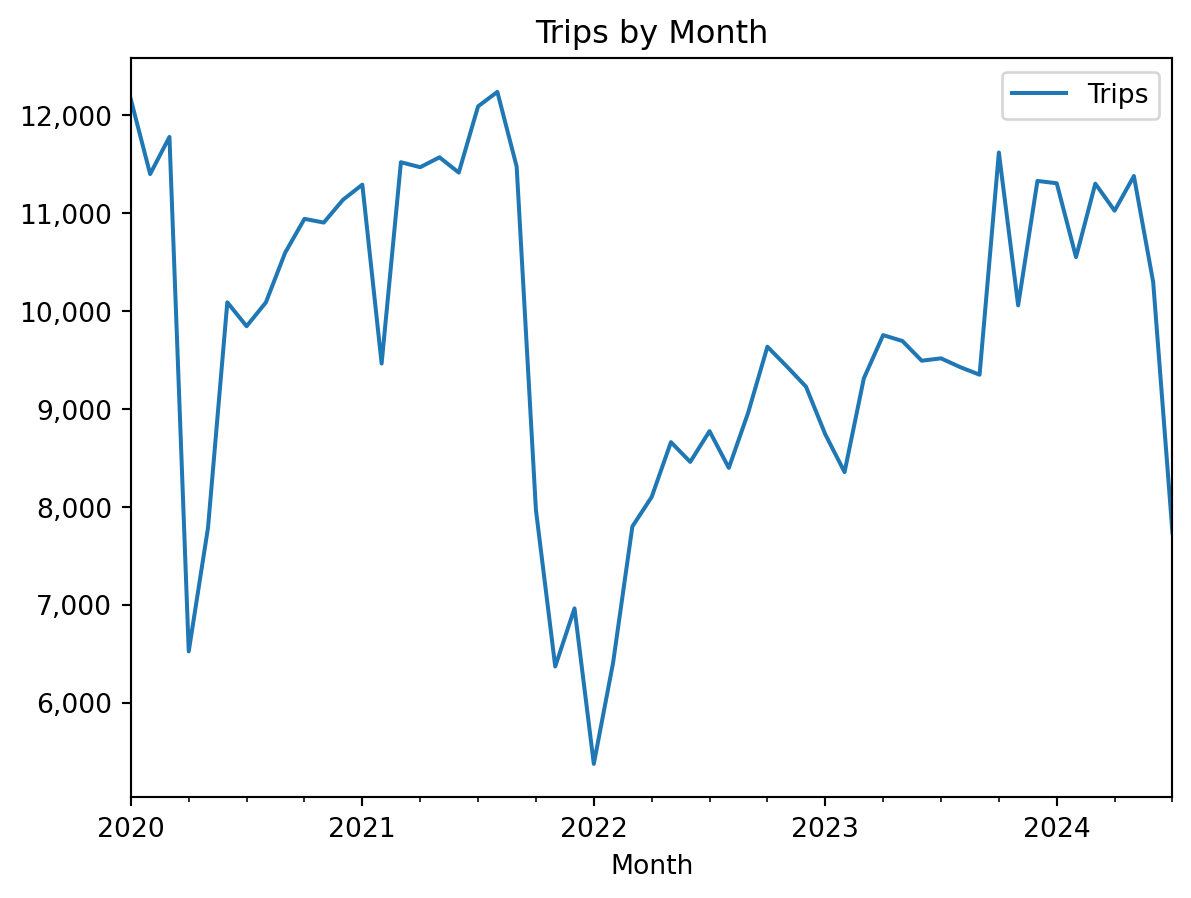

In [78]:
# | echo: false
import matplotlib.pyplot as plt
import matplotlib as mpl

ax = (
    vessel_history_clean.with_columns(
        pl.col("Date").dt.date().dt.month_start().alias("Month"),
    )
    .group_by("Month")
    .agg(pl.col("Vessel").count().alias("Trips"))
    .sort("Month")
    .to_pandas()
    .plot(
        x="Month",
        y="Trips",
        title="Trips by Month",
    )
)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))

plt.show()

## Task 7 - publish notebook as Quarto document to Posit Connect

### 🔄 Task

Deploy the notebook to Posit Connect as a Quarto document.

### 🧑‍💻 Code

Run the following to deploy the notebook to Connect:

```bash
# Check that you have the required environment variables set
echo $DATABASE_URI_PYTHON

# Publish the notebook
rsconnect deploy quarto --title "Seattle Ferries #2 - Data exploration and validation" -E DATABASE_URI_PYTHON notebook.ipynb
```

After the deployment is successful:

- Share the notebook with the person beside you.
- Schedule the notebook to run once every week.

In [79]:
print("Notebook complete ✅")

Notebook complete ✅
